# ID Card Tampering Detection

For the first project, we will develop an ID Tampering Detection App. This project aims to leverage computer vision techniques to detect tampered ID's, with the goal of providing a valuable tool for organizations to verify the authenticity of the ID cards presented to them by their employees, customers, or anyone else. By implementing this system, organizations can ensure that they are not being presented with fraudulent or tampered IDs, which can help protect against identity theft and other forms of fraud. To accomplish this, I will utilize the power of Google Colab to develop the algorithm, create a Flask application for ease of use, and ultimately deploy the system on the Heroku platform for accessibility and scalability.

First let's start  with necessary imports. 

"skimage.metrics" will provide an implementation of the Structural Similarity Index (SSIM) to compare two images.

"imutils" is a set of convenience functions to make basic image processing functions such as resizing, rotating, and cropping simpler.

"cv2" is the OpenCV library for computer vision and image processing. It will provide a wide range of functions for image manipulation, such as thresholding, edge detection, and feature detection.

"PIL (Python Imaging Library)" is a library for opening, manipulating and saving different image file formats.

The requests module will be used in for making HTTP requests to fetch data from a web server.

In [1]:
# import the necessary packages
from skimage.metrics import structural_similarity
import imutils
import cv2
from PIL import Image
import requests

Then, let's create our directories inside Google Colab. First command !mkdir id_card_tampering will create a new directory named "id_card_tampering" in the current working directory. We need ! at the beginning of the command  to run a shell command Jupyter Notebook or Google Colab.

The second command !mkdir id_card_tampering/image will create a sub-directory named "image" inside the "id_card_tampering" directory that was created in the previous command. This is where we will store the images that we will use for the tampering detection algorithm.

In [2]:
!mkdir id_card_tampering
!mkdir id_card_tampering/image

The following lines of code will download two images from the web using the requests module, and then use the Image class from the PIL module to open and read the images as objects.

The first line of code will download an image of an original ID card from a URL and read it as an image object using the Image.open() method. The stream=True parameter in the requests.get() method is used to load the image in streaming mode to conserve memory.

The second line of code will download an image of a tampered ID card from a different URL and read it as another image object using the Image.open() method. The stream=True parameter is again used to load the image in streaming mode.

After these two lines are executed, the original and tampered objects will contain the respective images as PIL image objects, which can be used for further processing or analysis.

In [3]:
original = Image.open(requests.get('https://www.thestatesman.com/wp-content/uploads/2019/07/pan-card.jpg', stream=True).raw)
tampered = Image.open(requests.get('https://assets1.cleartax-cdn.com/s/img/20170526124335/Pan4.png', stream=True).raw) 

In [4]:
# The file format of the source file.
print("Original image format : ",original.format) 
print("Tampered image format : ",tampered.format)

# Image size, in pixels. The size is given as a 2-tuple (width, height).
print("Original image size : ",original.size) 
print("Tampered image size : ",tampered.size) 

Original image format :  JPEG
Tampered image format :  PNG
Original image size :  (1200, 800)
Tampered image size :  (282, 179)


When we compare the image format and size of the original and tampered objects, we see that there are major differences. 

The results indicate that the original image is in JPEG format while the tampered image is in PNG format.Furthermore, the size of the original image is (1200, 800) pixels, which means it has a resolution of 1200 pixels wide and 800 pixels tall. On the other hand, the tampered image is much smaller with a size of (282, 179) pixels, indicating that it has a lower resolution than the original image.

These differences in format and size between the two images are important because they can impact the algorithms used for tampering detection. For example, image compression can introduce artifacts that may be mistaken for tampering, while smaller images may have fewer features for analysis.

#### Matching the Formats

Resizing the images to the same dimensions is important to ensure that the two images can be compared accurately for tampering detection. If the images are of different sizes, their pixel values will not align properly during the comparison process, leading to inaccurate results. 

The following lines of code will resize the original and tampered images to the same dimensions of 250 pixels width and 160 pixels height using the resize() method of the PIL image objects.

The new dimensions of the images are confirmed by the two print() statements that display the size of the resized images.
Finally, the save() method will be used to save the resized original and tampered images to the id_card_tampering/image directory using the filenames original.png and tampered.png, respectively.

Resizing the images to the same dimensions is important to ensure that the two images can be compared accurately for tampering detection. If the images are of different sizes, their pixel values will not align properly during the comparison process, leading to inaccurate results.

In [5]:
# Resize Image
original = original.resize((250, 160))
print(original.size)
original.save('id_card_tampering/image/original.png')#Save image
tampered = tampered.resize((250,160))
print(tampered.size)
tampered.save('id_card_tampering/image/tampered.png')#Saves image

(250, 160)
(250, 160)


Then, I will use the cv2.imread() function from the OpenCV library to read the original.png and tampered.png images that were previously resized and saved to the id_card_tampering/image directory.

The cv2.imread() function reads in the image file and returns a numpy array that represents the pixel values of the image. By default, cv2.imread() reads images in the BGR color format, which is different from the RGB format used by PIL.

Therefore, if we want to perform any operations on these images using OpenCV, we may need to convert the color format from BGR to RGB using the cv2.cvtColor() function. The cv2.cvtColor() function takes two arguments: the first argument is the image we want to convert, and the second argument is the color space conversion code. In this case, we are using the cv2.COLOR_BGR2GRAY code to convert the images to grayscale.

Grayscale images have only one color channel, representing the intensity of the image at each pixel. This makes them easier to process and analyze, especially for tasks such as edge detection and feature extraction, which are commonly used in computer vision.

In [6]:
# load the two input images
original = cv2.imread('id_card_tampering/image/original.png')
tampered = cv2.imread('id_card_tampering/image/tampered.png')

In [7]:
# Convert the images to grayscale
original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
tampered_gray = cv2.cvtColor(tampered, cv2.COLOR_BGR2GRAY)

#### Structural Similarity Index

The Structural Similarity Index (SSIM) is a widely-used metric in computer vision that enables us to identify the precise location of image differences in terms of their x and y coordinates. In this project, we are leveraging SSIM to determine the level of similarity between the original and tampered images.

The SSIM score ranges from 0 to 1, with a score of 1 indicating that the two images are identical. A lower SSIM score corresponds to a lower level of similarity between the two images and can help us identify any areas in which the images differ.

By analyzing the SSIM scores for different regions of the images, we can determine which areas have been modified or tampered with. This information can be used to pinpoint the exact location of the tampering, which can be useful for identifying the source of the tampering and potentially preventing future incidents. 

Following, I will use the structural_similarity() function which takes three arguments: the two grayscale images to compare, and a Boolean parameter full that specifies whether to return a full structural similarity image as well as the score. In this case, I have set full=True to obtain both the SSIM score and the structural difference image.

The diff variable will be assigned the structural difference image, which highlights the areas where the original and tampered images differ. This image is a grayscale image where white pixels indicate regions of high difference between the two images, while black pixels indicate regions of low difference. The astype() method is used to convert the difference image to an 8-bit unsigned integer (uint8) type for display purposes.

In [8]:
score, diff = structural_similarity(original_gray, tampered_gray, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.31678790332739426


According to the result, the SSIM score of 0.31678 indicates that there is a relatively low level of similarity between the original and tampered images.

Since the SSIM score ranges from 0 to 1, with 1 indicating perfect similarity and 0 indicating complete dissimilarity, a score of 0.31678 suggests that there are significant differences between the two images.

By examining the structural difference image, we can determine the specific regions in which the images differ, which can provide valuable insights for identifying the source of the tampering and potentially preventing future incidents.

Hence, I will utilize the threshold function from the computer vision library to transform the grayscale image into a binary image. This function will apply an adaptive threshold to the image, which is stored in the form of a numpy array. The adaptive thresholding method uses a mathematical formula to determine the threshold level for each pixel based on its surrounding pixels, resulting in a binary image with clearer edges and less noise.

Once we have obtained the binary image, we can use the findContours() function to identify and retrieve the contours present in the image. Contours are the boundaries that define the shape of the objects present in an image and can be useful for shape analysis and recognition. The findContours() function works specifically on binary images and returns the contours as a list of numpy arrays.

To extract the appropriate values of the contours, I will use the grab_contours() function, which is a convenience function that works with both OpenCV 2 and OpenCV 3. This function returns the contours as a single list, making it easier to work with the contours for further analysis or processing.

In [9]:
# Calculating threshold and contours 
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

Next, I will use the concept of a bounding rectangle to help us analyze the shapes present in the images and identify any differences between them. The bounding rectangle is a rectangular box that encloses a contour, providing a useful tool for shape analysis and comparison. By computing the bounding rectangle for the contours in both the original and tampered images, we can determine the ratio of width to height of the rectangle, which can be used to identify any areas in which the images differ.

To obtain the bounding rectangle for each contour, I will use the cv2.boundingRect() function, which returns the (x, y) coordinates of the upper left corner of the rectangle, as well as its width and height. I then will use these values to draw a bounding box around the contour in both the original and tampered images using the cv2.rectangle() function.

The cv2.rectangle() function takes several arguments, including the image on which to draw the rectangle, the coordinates of the upper left and lower right corners of the rectangle, the color of the rectangle, and the line thickness. By drawing the bounding rectangle on both input images, we can clearly see where the two images differ and identify any areas in which tampering may have occurred.

The for loop in the next code iterates over the contours present in the binary image and applies the cv2.boundingRect() function to each contour. The resulting coordinates are used to draw a bounding box around the contour in both the original and tampered images using the cv2.rectangle() function. The x and y coordinates represent the upper left corner of the bounding box, while the w and h values represent the width and height of the box. The rectangles are drawn in red ((0, 0, 255)) with a line thickness of 2 pixels. By analyzing the resulting bounding boxes, we can identify any regions where the original and tampered images differ.

In [10]:
# loop over the contours
for c in cnts:
    # applying contours on image
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(tampered, (x, y), (x + w, y + h), (0, 0, 255), 2)

As the final step, we will look at the difference and threshold images to observe the case visually. The following code will use the Image.fromarray() function from the PIL library to display the structural difference image (diff) and the binary threshold image (thresh) that were generated earlier.

The Image.fromarray() function takes a numpy array as input and returns an Image object that can be displayed or saved. By calling Image.fromarray(diff) and Image.fromarray(thresh), we can display the difference and threshold images in a format that is easy to view and analyze.

It's important to note that the print() statements will not display the images themselves, but rather an object representing the image. To actually display the images, we would need to use a method like imshow() or show(), depending on the specific library we are using.

Different Image


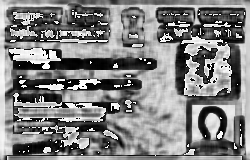

In [11]:
#Diplay difference image with black
print('Different Image')
Image.fromarray(diff)

Threshold Image


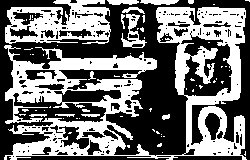

In [12]:
#Display threshold image with white
print('Threshold Image')
Image.fromarray(thresh)

### Summary 

Until now, we used the Structural Similarity Index (SSIM) to determine the level of similarity between an original image and a potentially tampered image. We also utilized thresholding and contour detection techniques to perform shape analysis and recognition on the images.
By calculating the SSIM score, we were able to determine that the tampered image provided by the user was likely fake or tampered. By analyzing the structural difference image, we identified the specific regions where the tampering had occurred, which can provide valuable insights for detecting and preventing future incidents.
Finally, we visualized the differences and similarities between the images by displaying the images with contours, difference, and threshold.